In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_preprocessing import timepoint_split, transform_indices, reindex_data
from evaluation import model_evaluate, topn_recommendations

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6

## MovieLens-1M

In [2]:
#!mkdir data
#!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
#!unzip ml-1m.zip -d data

In [3]:
movielens = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["userid", "itemid", "rating", "timestamp"], engine="python")

In [4]:
movielens.nunique()

userid         6040
itemid         3706
rating            5
timestamp    458455
dtype: int64

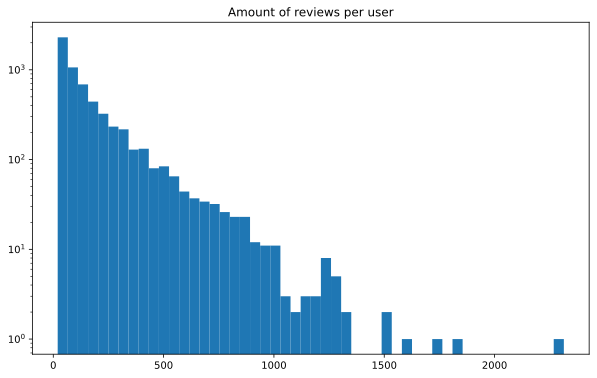

In [5]:
plt.hist(movielens.groupby("userid").size(), bins=50)
plt.yscale("log")
plt.title("Amount of reviews per user")
plt.show()

In [6]:
# Split for final evaluation
_train, _test, _holdout = timepoint_split(movielens, time_split_q=0.95)

len(_train), len(_test), len(_holdout)

(725370, 221697, 802)

In [7]:
# Additional split for hyperparameter tuning
_trainval, _testval, _holdoutval = timepoint_split(_train, time_split_q=0.95)

len(_trainval), len(_testval), len(_holdoutval)

(611093, 77989, 407)

In [8]:
def reindex_all(train, test, holdout=None, userid='userid', itemid='itemid'):
    train_new, data_index = transform_indices(train, userid, itemid)
    test_new = reindex_data(test, data_index, fields='items')
    
    if holdout is None:
        return train_new, test_new, data_index
    
    holdout_new = reindex_data(holdout, data_index, fields='items')
    return train_new, test_new, holdout_new, data_index


trainval, testval, holdoutval, data_index_val = reindex_all(_trainval, _testval, _holdoutval)

## Popular

In [9]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "items": "itemid",
    "users": "userid",
}

In [10]:
topn = 10

In [11]:
alphas = [2 ** p for p in range(9)]

popular_results = []

for a in alphas:
    def damped_mean(ratings):
        return sum(ratings) / (len(ratings) + a)
    
    item2rating = trainval.groupby('itemid')["rating"].apply(damped_mean)
    best_items = item2rating.nlargest(topn).index.values
    popular_recs = np.ones((len(holdoutval), topn)) * best_items
    metric = model_evaluate(popular_recs, holdoutval, data_description, topn)    
    
    popular_results.append({
        "alpha": a, "metric": metric
    })

popular_results = pd.DataFrame(popular_results)

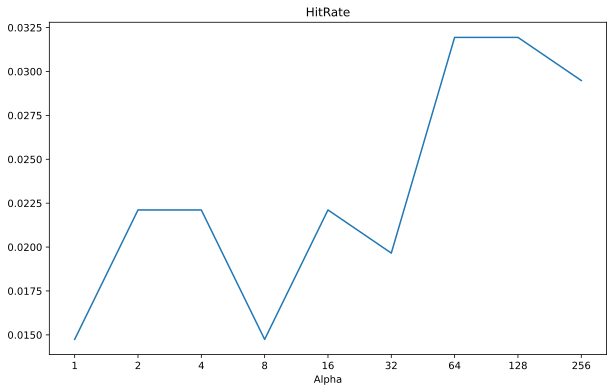

In [12]:
plt.plot(popular_results["alpha"], popular_results["metric"])
plt.xscale("log")
plt.xticks(popular_results["alpha"], popular_results["alpha"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Alpha")

plt.show()

## Pure SVD

In [13]:
from pure_svd import build_svd_model, svd_scoring, svd_gridsearch

In [14]:
ranks = [b * 2 ** p for p in range(0, 7) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192]

In [15]:
results = svd_gridsearch(ranks, trainval, testval, holdoutval, data_description, topn, sample=True)

results = pd.DataFrame(results)

Interaction matrix shape: (4662, 3630)
Matrix density: 0.03611007701916793


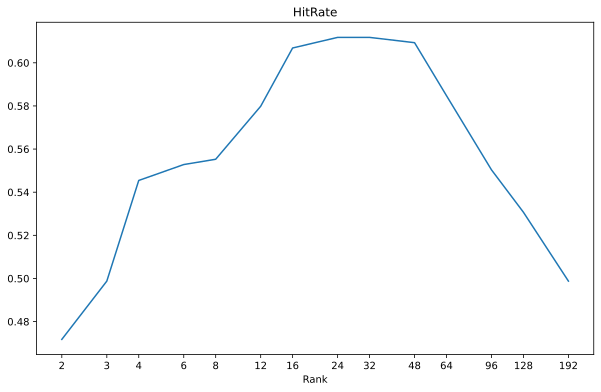

In [16]:
plt.plot(results["rank"], results["metric"])
plt.xscale("log")
plt.xticks(results["rank"], results["rank"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Rank")

plt.show()

In [17]:
best_rank = results.sort_values("metric")["rank"].iloc[-1]
print("Best rank:", best_rank)

model = build_svd_model({"rank": best_rank}, trainval, data_description)
scores = svd_scoring(model, testval, holdoutval, data_description, sample=True)
svd_recs = topn_recommendations(scores, topn)

Best rank: 32
Interaction matrix shape: (4662, 3630)
Matrix density: 0.03611007701916793


In [18]:
print("HitRate:", model_evaluate(svd_recs, holdoutval, data_description, topn))

HitRate: 0.6044226044226044


## Scaled SVD

In [19]:
from scaled_svd import build_scaled_svd_model, scaled_svd_gridsearch

In [20]:
ranks = [b * 2 ** p for p in range(0, 7) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192]

In [21]:
scalings = np.arange(1, 10) / 10
scalings

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [22]:
results = scaled_svd_gridsearch(ranks, scalings, trainval, testval, holdoutval, data_description, topn, sample = True)

Scaling 0.1
Scaling 0.2
Scaling 0.3
Scaling 0.4
Scaling 0.5
Scaling 0.6
Scaling 0.7
Scaling 0.8
Scaling 0.9


In [23]:
results = pd.DataFrame(results)

results = results.sort_values("metric", ascending=False)

results.head()

,rank,scaling,metric
35,24,0.3,0.680590
36,32,0.3,0.656020
22,32,0.2,0.656020
7,24,0.1,0.656020
79,48,0.6,0.653563
